In [1]:
import time
import sys 
import os

import numpy as np
from quantileKernelMixCp.quikmix import QuiKMixCP
from quantileKernelMixCp.generate_qkm import *
from quantileKernelMixCp.utils import *

## Generate data 
- true topic proportions $W$ are estimated via topic modeling
- Kernel: Gaussian kernel on distance of $[clr(W),X_0]$
- $f(x) = \beta_0 + W_{1:K}^{\top}\beta_1 + \frac{1}{\lambda}K(x)\theta$

In [2]:
N = 1000 # document length
n = 1000 # number of samples
p = 50 # X1 dimension (number of words)
p0 = 3 # X0 dimension (number of non-topic related covariates)
K = 3 # W dimenstion (number of topics)
covariate_W = False # do we know true topic proportion
extra_covariate = True # whether we have covariates not related to topics

test_prop = 0.1
calib_prop = 0.3

alpha = 0.1 # 1-coverage
gamma = None # scale parameter in Gaussian kernel, if not specified, QuiKMix automatically optimizes it

# === Simulate data ===
seed = 111
np.random.seed(seed)
X, y, D, W, A = generate_data(N, n, p, p0, K, test_prop, covariate_W, extra_covariate)
splits = split_data(X, y, calib_prop, test_prop, seed)
            
X_train, y_train, train_idx = splits['train']
X_calib, y_calib, calib_idx = splits['calib']
X_test, y_test, test_idx = splits['test']

reg = LinearRegression().fit(X_train, y_train.ravel())
scoresCalib = np.abs(reg.predict(X_calib) - y_calib.ravel())
scoresTest =  np.abs(reg.predict(X_test) - y_test.ravel())

## Method 1: Quantile Kernel regression using solution path

In [3]:
print("Starting QKMCP...")
Smin = np.min(scoresCalib)
Smax = np.max(scoresCalib)
start_time = time.time()
quiKMix = QuiKMixCP(alpha = alpha, K = K, p = p, rand_seed=seed)
quiKMix.train(X_train, X_calib, X_test, y_train, y_calib, y_test) # train predictor, estimate topics, optimize gamma
covers_qkm_rand, covers_qkm = quiKMix.fit() # get randomized / non-randomized coverage
covers_qkm_rand = np.concatenate(covers_qkm_rand)
covers_qkm = np.array(covers_qkm)
cutoffs_qkm  = quiKMix.predict(Smin, Smax) # get prediction size
time_qkm = time.time()-start_time

Starting QKMCP...
Optimal gamma is 8.858667904100825.


Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
for k in range(K):
    topic_weight = W[test_idx, k]
    shiftcov = np.mean(covers_qkm_rand * topic_weight) / np.mean(topic_weight)
    print(f"Re-weighted coverage for topic {k} is {shiftcov}.")
wsc_val = wsc_unbiased(X[test_idx], covers_qkm_rand)

Re-weighted coverage for topic 0 is 0.898307874693904.
Re-weighted coverage for topic 1 is 0.9505771105845869.
Re-weighted coverage for topic 2 is 0.8976266369802858.


## Method 2: Split CP

In [5]:
nCalib = len(scoresCalib)
cutoff_scp = np.quantile(scoresCalib, [(1-alpha) * (1 + 1/nCalib)])
covers_scp = scoresTest <= cutoff_scp
cutoff_scp = [cutoff_scp[0]]*100

In [6]:
for k in range(K):
    topic_weight = W[test_idx, k]
    shiftcov = np.mean(covers_scp * topic_weight) / np.mean(topic_weight)
    print(f"Re-weighted coverage for topic {k} is {shiftcov}.")
wsc_val = wsc_unbiased(X[test_idx], covers_scp)

Re-weighted coverage for topic 0 is 0.8666330441026099.
Re-weighted coverage for topic 1 is 0.9468255389820502.
Re-weighted coverage for topic 2 is 0.888333087179582.


## Plot

/opt/anaconda3/envs/llm-env/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


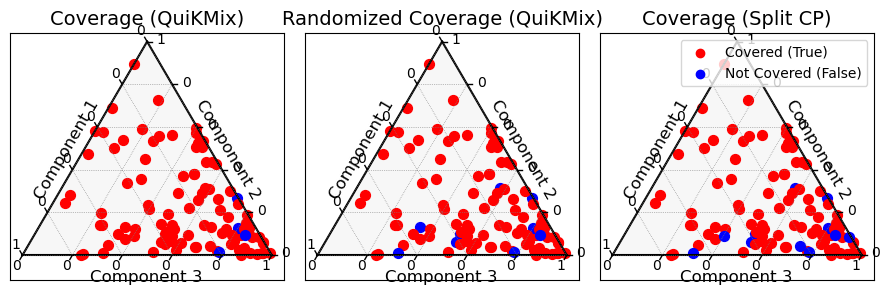

Coverage for our method: 0.91, Coverage for SplitCP: 0.89


/var/folders/0b/w1czghy14lgbrx9zm77dkkvw0000gn/T/ipykernel_79947/529354081.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


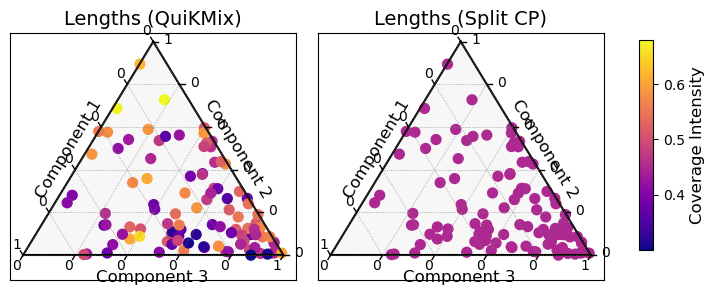

In [7]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

Wtest = W[test_idx]
data_points = [tuple(row) for row in Wtest[:,:K]]
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
plot_ternary(data_points, covers_qkm, "Coverage (QuiKMix)", axs[0])
plot_ternary(data_points, covers_qkm_rand, "Randomized Coverage (QuiKMix)", axs[1])
plot_ternary(data_points, covers_scp, "Coverage (Split CP)", axs[2])
plt.scatter([], [], color='red', label="Covered (True)")
plt.scatter([], [], color='blue', label="Not Covered (False)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
print(f"Coverage for our method: {np.mean(covers_qkm_rand)}, Coverage for SplitCP: {np.mean(covers_scp)}")

cmap = cm.plasma
vmin = np.min(cutoffs_qkm)
vmax = np.max(cutoffs_qkm)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
scatter1 = plot_ternary_size(data_points, cutoffs_qkm, "Lengths (QuiKMix)", axs[0], vmin, vmax)
scatter2 = plot_ternary_size(data_points, cutoff_scp, "Lengths (Split CP)", axs[1], vmin, vmax)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Coverage Intensity", fontsize=12)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()